In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
from rasterio.enums import Resampling
from shapely.geometry import box
from rasterio.plot import plotting_extent
import pandas as pd
import numpy as np
import contextily as ctx #basemaps in EPSG:4326
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.patches import Patch, Polygon, Circle, Rectangle
from pathlib import Path

In [3]:
def round_to(n, precision):
    correction = 0.5 if n >= 0 else -0.5
    return int( n/precision+correction ) * precision

def format_axis(axis,xlim,ylim,step=1,places=0,show_axis=True):
        
    axis.set(xlim=xlim,ylim=ylim)
    
    if show_axis:
        xticks = np.arange(round_to(xlim[0],step)+step, xlim[1],step)
        yticks = np.arange(round_to(ylim[0],step)+step, ylim[1],step)
        
        axis.set(xticks=xticks,yticks=yticks)

        if xlim[0] > 0:
            xdir = 'W'
        else:
            xdir = 'E'

        if ylim[0] > 0:
            ydir = 'N'
        else:
            ydir = 'S'

        xlabels = [f'{round(abs(x),places)}$\degree${xdir}' for x in xticks]
        ylabels = [f'{round(abs(x),places)}$\degree${ydir}' for x in yticks]

        axis.set_xticklabels(xlabels)
        axis.set_yticklabels(ylabels)
    
    else:
        axis.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    
    return axis

def add_north_arrow(axis,x=0.06, y=0.96, arrow_length=0.1, color='black'):
    axis.annotate('N', xy=(x, y), xytext=(x, y-arrow_length), color=color,
            arrowprops=dict(color=color, width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=axis.transAxes)
    return axis

def add_scale_bar(axis,width=100,height=15,label='100 m',loc='lower right',color='black'):
    scalebar = AnchoredSizeBar(axis.transData, width, label, loc,
                           pad=0.1,
                           size_vertical=height,
                           color=color,
                           frameon=False,
                           label_top=True)

    axis.add_artist(scalebar)
    return axis

def read_raster(path,bands=1,rgb=False,resample_factor=None):
    with rio.open(path) as dst:
        crs = dst.crs
        extent = plotting_extent(dst)
        
        if resample_factor:
            out_shape=(dst.count,int(dst.height * resample_factor),int(dst.width * resample_factor))
            data = dst.read(out_shape=out_shape,resampling=Resampling.bilinear)
        else:
            data = dst.read(bands)

    if rgb:
        data = np.moveaxis(data,0,-1)

    return (data, crs, extent)

In [11]:
gdf = gpd.read_file('bird_point_tracking.shp')
gdf = gdf.rename(columns={'easting':'east','northing':'north'})

In [50]:
cps = gdf.loc[gdf['type']=='c'].copy().pivot(index='id', columns='year', values=['east','north'])
cps.columns = [f'{d}_{y}' for d,y in cps.columns]
cps = cps.reset_index()

cps['east_offset'] = cps.east_2021 - cps.east_2016
cps['north_offset'] = cps.north_2021 - cps.north_2016

In [51]:
cps

,id,east_2016,east_2021,north_2016,north_2021,east_offset,north_offset
0,1,399644.791,399645.293,5611457.127,5611457.646,0.502,0.519
1,2,399626.497,399626.612,5611457.429,5611457.532,0.115,0.103
2,3,399626.800,399626.903,5611435.232,5611435.334,0.103,0.102
3,4,399755.419,399755.813,5611436.441,5611436.768,0.394,0.327
4,5,399742.809,399743.249,5611459.501,5611460.028,0.440,0.527
5,6,399463.996,399464.395,5611463.117,5611463.503,0.399,0.386
6,7,399530.464,399530.570,5611526.664,5611527.058,0.106,0.394
7,8,398910.132,398910.469,5612428.375,5612428.907,0.337,0.532
8,9,399194.912,399194.928,5612987.545,5612987.531,0.016,-0.014
9,10,399440.560,399441.302,5612899.697,5612900.078,0.742,0.381


In [55]:
error = cps[['east_offset','north_offset']].describe()
error

,east_offset,north_offset
count,15.000000,15.000000
mean,0.436733,0.220933
std,0.280736,0.239117
min,0.016000,-0.163000
25%,0.226000,0.045000
50%,0.434000,0.219000
75%,0.612000,0.390000
max,0.987000,0.532000


In [60]:
lps = gdf.loc[gdf['type']=='l'].copy().pivot(index='id', columns='year', values=['east','north'])
lps.columns = [f'{d}_{y}' for d,y in lps.columns]
lps = lps.reset_index()

lps['east_offset'] = (lps.east_2021 - lps.east_2016 + error.loc['mean','east_offset']).round(2)
lps['north_offset'] = (lps.north_2021 - lps.north_2016 + error.loc['mean','north_offset']).round(2)

lps['e_rate'] = lps.east_offset / (2021-2016)
lps['n_rate'] = lps.north_offset / (2021-2016)

In [61]:
lps

,id,east_2016,east_2021,north_2016,north_2021,east_offset,north_offset,e_rate,n_rate
0,16,399609.492,399617.173,5611896.566,5611888.599,8.12,-7.75,1.624,-1.550
1,17,399649.591,399657.409,5611904.639,5611897.524,8.25,-6.89,1.650,-1.378
2,18,399631.299,399638.813,5611998.912,5611992.029,7.95,-6.66,1.590,-1.332
3,19,399470.019,399472.264,5611628.194,5611625.669,2.68,-2.30,0.536,-0.460
4,20,399430.337,399431.103,5611615.906,5611612.987,1.20,-2.70,0.240,-0.540
5,21,399371.901,399372.641,5611590.238,5611583.889,1.18,-6.13,0.236,-1.226
6,22,399236.137,399238.406,5611801.352,5611793.231,2.71,-7.90,0.542,-1.580
7,23,399384.339,399389.169,5611803.489,5611792.652,5.27,-10.62,1.054,-2.124
8,24,399410.061,399414.454,5611792.456,5611783.138,4.83,-9.10,0.966,-1.820
9,25,399337.810,399345.492,5612219.600,5612201.591,8.12,-17.79,1.624,-3.558


In [62]:
lps.to_csv('bird_point_survey.csv')

In [67]:
bird, crs, bird_extent = read_raster('bird_horizons.tif',bands=[1,2,3],rgb=True)

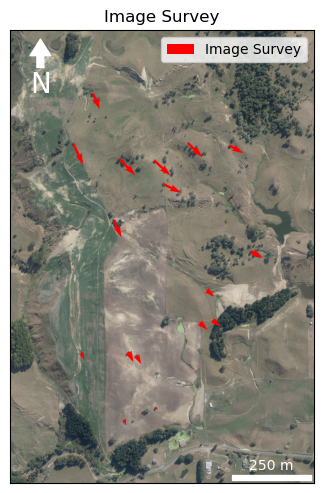

In [70]:
# Setup
b = 100
w, e, s, n = [lps.east_2016.min()-b,lps.east_2016.max()+b,lps.north_2016.min()-b,lps.north_2016.max()+b]
options = dict(angles='xy',scale_units='xy',scale=0.066,width=0.0075)

fig, ax1 = plt.subplots(1,1,figsize=(6,6),dpi=100)

# Pegs
ax1.quiver(lps.east_2016, lps.north_2016, lps.e_rate, lps.n_rate,color='red',label='Image Survey',**options)
ax1.imshow(bird,extent=bird_extent,interpolation=None)

ax1.legend(loc='upper right', frameon=True)

ax1 = format_axis(ax1,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)
ax1 = add_north_arrow(ax1,x=0.1, y=0.98, arrow_length=0.1,color='white')
ax1 = add_scale_bar(ax1,width=250,label='250 m',color='white')
ax1.set_title('Image Survey')

# fig.colorbar(ew_plot, ax=ax2, shrink=0.9)
# fig.colorbar(ns_plot, ax=ax3, shrink=0.9)

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig('pegs.png',dpi=300,bbox_inches='tight')